In [2]:
import pandas as pd

# Memuat dataset dari file CSV yang tersedia
df = pd.read_csv('/content/ulasan_aplikasi_bahasa__preprocessing_final.csv')

# Menampilkan 5 baris pertama dari DataFrame
display(df.head())

,app_name,rating,review,preprocessed_text
0,Duolingo,5,duolingo mengajariku bahasa Jepang sekarang ak...,ajar bahasa jepang paham bahasa jepang
1,Duolingo,5,"bagus,bisa untuk belajarr",bagus ajar
2,Duolingo,5,"sangat melatih, aplikasinya juga bagus",latih aplikasi bagus
3,Duolingo,5,sangat seru terasa bermain tapi menambah ilmu ...,seru main tambah ilmu suka banget
4,Duolingo,5,cara mudah belajar bahasa sangat mantap,mudah ajar bahasa mantap


# Esplorasi Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   app_name           1362 non-null   object
 1   rating             1362 non-null   int64 
 2   review             1362 non-null   object
 3   preprocessed_text  1352 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.7+ KB


In [4]:
df.isnull().sum()

,0
app_name,0
rating,0
review,0
preprocessed_text,10


In [5]:
#menghapus missing values dari dataset
df = df.dropna(subset=['preprocessed_text'])

print("Shape of df after dropping nulls:", df.shape)
display(df.isnull().sum())

Shape of df after dropping nulls: (1352, 4)


,0
app_name,0
rating,0
review,0
preprocessed_text,0


# Text Vectorization (TF-IDF)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'preprocessed_text' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

print("Shape of TF-IDF matrix:", tfidf_matrix.shape)
print("Number of features (unique words):", len(tfidf_vectorizer.get_feature_names_out()))

Shape of TF-IDF matrix: (1352, 1584)
Number of features (unique words): 1584


# Elbow Method

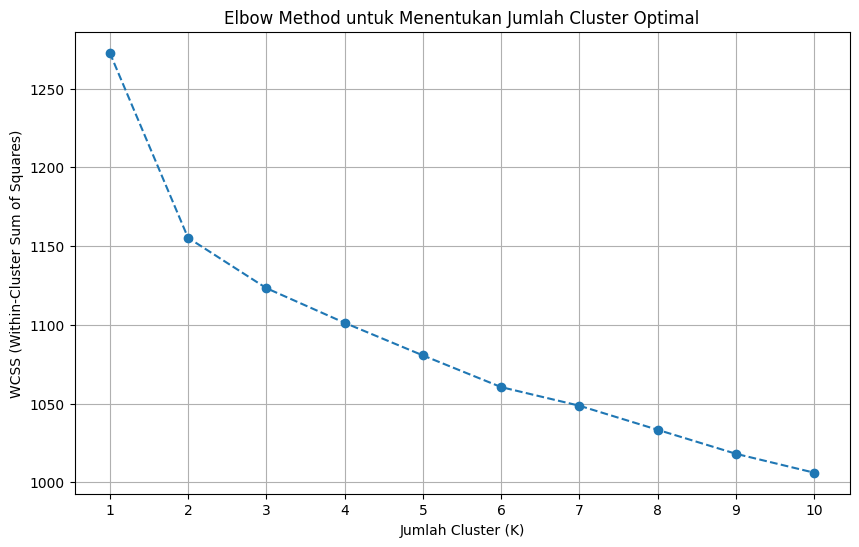

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

wcss = []
k_range = range(1, 11) # Mencoba k dari 1 hingga 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10) # n_init diatur eksplisit
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

# Memvisualisasikan hasil elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# K-Means Clustering

In [50]:
from sklearn.cluster import KMeans

# Menentukan jumlah cluster (misal, berdasarkan elbow method)
n_clusters = 2

# Inisialisasi model KMeans
kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)

# Melatih model pada matriks TF-IDF
kmeans_model.fit(tfidf_matrix)

# Mendapatkan label cluster untuk setiap dokumen
cluster_labels = kmeans_model.labels_

# Menambahkan label cluster ke DataFrame asli
df['cluster_label'] = cluster_labels

# Menampilkan 5 baris pertama DataFrame dengan label cluster baru
display(df.head())

,app_name,rating,review,preprocessed_text,cluster_label
0,Duolingo,5,duolingo mengajariku bahasa Jepang sekarang ak...,ajar bahasa jepang paham bahasa jepang,1
1,Duolingo,5,"bagus,bisa untuk belajarr",bagus ajar,0
2,Duolingo,5,"sangat melatih, aplikasinya juga bagus",latih aplikasi bagus,1
3,Duolingo,5,sangat seru terasa bermain tapi menambah ilmu ...,seru main tambah ilmu suka banget,1
4,Duolingo,5,cara mudah belajar bahasa sangat mantap,mudah ajar bahasa mantap,1


# Topic Modeling with NMF (Non-negative Matrix Factorization)


In [51]:
from sklearn.decomposition import NMF

# Instantiate NMF model with 2 components
n_topics = 2
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda')

# Fit the NMF model to the tfidf_matrix and transform it
nmf_features = nmf_model.fit_transform(tfidf_matrix)

# Get the components (word distribution for each topic)
nmf_components = nmf_model.components_

print(f"Shape of NMF features (documents x topics): {nmf_features.shape}")
print(f"Shape of NMF components (topics x features): {nmf_components.shape}")

Shape of NMF features (documents x topics): (1352, 2)
Shape of NMF components (topics x features): (2, 1584)


In [52]:
import numpy as np

# Get the dominant topic for each document
dominant_topics = np.argmax(nmf_features, axis=1)

# Add the dominant topic as a new column to the DataFrame
df['topic_label'] = dominant_topics

print("Dominant topics assigned to reviews.")
display(df.head())

Dominant topics assigned to reviews.


,app_name,rating,review,preprocessed_text,cluster_label,topic_label
0,Duolingo,5,duolingo mengajariku bahasa Jepang sekarang ak...,ajar bahasa jepang paham bahasa jepang,1,1
1,Duolingo,5,"bagus,bisa untuk belajarr",bagus ajar,0,0
2,Duolingo,5,"sangat melatih, aplikasinya juga bagus",latih aplikasi bagus,1,0
3,Duolingo,5,sangat seru terasa bermain tapi menambah ilmu ...,seru main tambah ilmu suka banget,1,1
4,Duolingo,5,cara mudah belajar bahasa sangat mantap,mudah ajar bahasa mantap,1,1


# Visualisasi Cluster

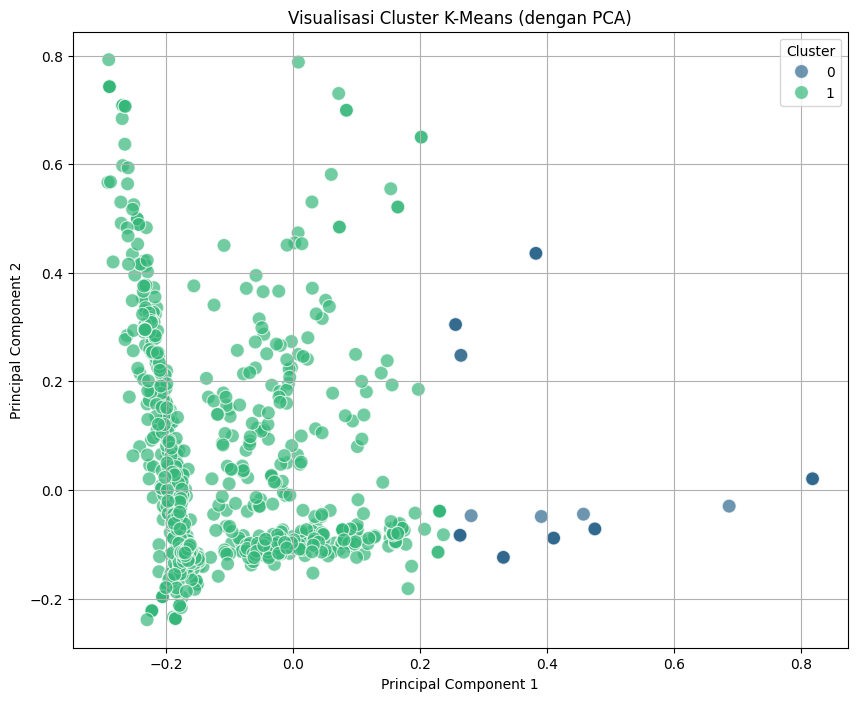

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Mengurangi dimensi TF-IDF matrix ke 2 komponen menggunakan PCA
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(tfidf_matrix.toarray()) # tfidf_matrix biasanya sparse, perlu diubah ke dense array

# Membuat DataFrame untuk visualisasi
pca_df = pd.DataFrame(data = pca_components, columns = ['PC1', 'PC2'])
pca_df['cluster_label'] = df['cluster_label'].values # Pastikan indeks cocok

# Memvisualisasikan cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_label', data=pca_df,
                palette='viridis', s=100, alpha=0.7)
plt.title('Visualisasi Cluster K-Means (dengan PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

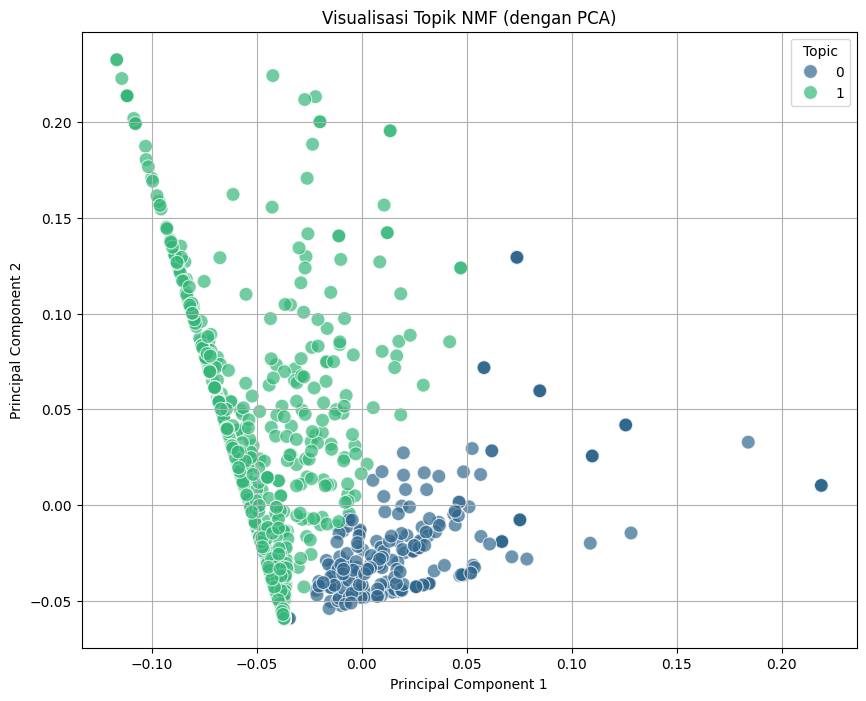

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Mengurangi dimensi NMF features (distribusi dokumen-topik) ke 2 komponen menggunakan PCA
pca_nmf = PCA(n_components=2, random_state=42)
pca_nmf_components = pca_nmf.fit_transform(nmf_features)

# Membuat DataFrame untuk visualisasi
nmf_pca_df = pd.DataFrame(data = pca_nmf_components, columns = ['PC1', 'PC2'])
nmf_pca_df['topic_label'] = df['topic_label'].values # Pastikan indeks cocok

# Memvisualisasikan topik
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='topic_label', data=nmf_pca_df,
                palette='viridis', s=100, alpha=0.7)
plt.title('Visualisasi Topik NMF (dengan PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Topic')
plt.show()